In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

W0905 22:02:37.885223 4726371776 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Getting our priorities straight
Up until now, we have mostly ignored our choice of priors. This is unfortunate as we can be very expressive with our priors, but we also must be careful about choosing them. This is especially true if we want to be objective, that is, not to express any personal beliefs in the priors.

### Subjective vs Objective priors
Bayesian priors can be classified into two classes: *objective* priors, which aim to allow the data to influence the posterior the most, and *subjective* priors, which allow the practioner to express his or her views into the prior.

What is an example of an objective prior? We have seen some already, including the *flat* prior, which is a uniform distribution over the entire possible range of the unknown. Using a flat prior implies that we give each possible value an equal weighting. Choosing this type of prior is invoking what is called 'The principle of indifference', literally we have no prior reason to favour one value over another. Calling a flat prior over a restricted space an objective prior is not correct, though it seems similar. If we know $p$ in a Binomial model is greater than 0.5, then $\mathrm{Uniform}(0.5, 1)$ is not an objective prior, since we have used prior knowledge, even though it is 'flat' over [0.5, 1]. The flat prior must be flat along the *entire* range of possibilities.

#### Subjective Priors
On the other hand, if we added more probability mass to certain areas of the prior, and less elsewhere, we are biasing our inference towards the unknowns existing in the former area. This is known as a subjective or *informative* prior. In the figure below, the subjective prior reflects a belief that the unknown likely lives around 0.5, and not around the extremes. The objective prior is insensitive to this.

## Empirical Bayes
*Empirical Bayes* is a trick that combines frequentist and Bayesian inference. For every inference problem there is a Bayesian method and a frequentist method. The significant difference between the two is that Bayesian methods have a prior distribution, with hyperparameters $\alpha$, while empirical methods do not have any notion of a prior. Empirical Bayes combines the two methods by using frequentist methods to select $\alpha$, and then proceeds with Bayesian methods on the original problem.

A simple example: suppose we wish to estimate the parameter $\mu$ of a Normal distribution, with $\sigma=5$. Since $\mu$ could range over the whole real line, we can use a Normal distribution as a prior for $\mu$. Note, this is the prior for $\mu$, where $\mu$ is the mean of another Normal distribution. How to select the prior's hyperparameters, denoted $(\mu_p, \sigma_p^2)$? The $\sigma_p^2$ parameter can be chosen to reflect the uncertainty we have. For $\mu_p$, we have two options:

**Option 1**: Empirical Bayes suggests using the empirical sample mean, which will center the prior around the observed empirical mean:

$$
\mu_p = \frac{1}{N}\sum_{i=}^N X_i
$$
(I don't understand here that the prior is already chosen by the data - subjective prior. But I guess you haven't used maximum likelihood on it)

**Option 2**: Traditional Bayesian inference suggests using no prior knowledge, or a more objective prior (zero mean and fat standard deviation). *Nevertheless you've decided to choose a Normal prior, so there's some level of subjectivity involved*

Empirical Bayes can be argued as being semi-objective, since while the choice of prior model is ours (hence subjective), the parameters are solely determined by data.

I totally agree that Empirical Bayes is *double-counting* the data. We are using the data once in the prior, which will influence our results towards the observed data, and again in the inferential engine of MCMC. This double counting will understate our true uncertainty. So use Empirical Bayes only if you have a *lot* of observation, else the prior will have too strong an influence.

### The Gamm distribution
$X \sim \mathrm{Gamma}(\alpha,\beta)$, is a random variable over the real numbers. It is a generalization of the Exponential random variable,

$$
\mathrm{Exp}(\beta) \sim \mathrm{Gamma}(1, \beta)
$$

PDF:

$$
f(x | \alpha, \beta) = \frac{\beta x^{\alpha-1} e^{-\beta x}}{\Gamma(\alpha)}
$$
where $\Gamma(\alpha)$ is the Gamma function

$$
\Gamma(x) = \int_0^\infty x^{z-1}e^{-x}dx
$$
For differing values of $(\alpha, \beta)$ looks like

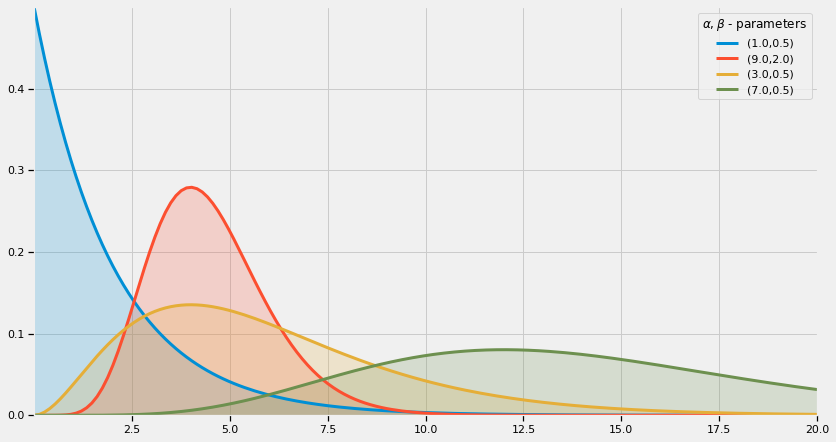

In [4]:
parameters = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]
x = tf.cast(tf.linspace(start=0.001, stop=20., num=150), dtype=tf.float32)

plt.figure(figsize=(12.5, 7))
for alpha, beta in parameters:
    [
        y_,
        x_
    ] = evaluate([
        tfd.Gamma(float(alpha), float(beta)).prob(x),
        x,
    ])
    lines = plt.plot(x_, y_, label = "(%.1f,%.1f)"%(alpha, beta), lw=3)
    plt.fill_between(x_, 0, y_, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title=r"$\alpha, \beta$ - parameters");

### The Wishart distribution

Until now, we have only seen random variables that are scalars. We can also have *random matrices*! Specifically, the Wishart distribution is a distribution over all positive semi-definite matrices. It is a generalization to multiple dimensions of the gamma distribution.

In Bayesian statistics, the Wishart distribution is the **conjugate prior** of the inverse covariance-matrix of a **multivariate normal random vector**.

Suppose $G$ is a $p\times n$ matrix, each column of which is independently drawn from a $p$-variate normal distribution with zero mean:

$$
G_{(i)} = (g_i^1, \ldots, g_i^p)^T \sim N_p(0, V)
$$

Then the Wishart distribution is the probability distribution of the $p\times p$ random matrix

$$
S = GG^T = \sum_{i=1}^n G_{(i)}G^T_{(i)}
$$

known as the scatter matrix. One indicates that $S$ has that probability distribution by writing 

$$
S \sim W_p(V, n)
$$

The positive integer $n$ is the number of degrees of freedom. Sometimes this is written $W(V,p,n)$. For $n\ge p$ the matrix $S$ is invertible with probability 1 if $V$ is invertible.

If $p=V=1$ then this distribution is a chi-squared distribution with $n$ degrees of freedom.

Why is this useful to have in our arsenal? (Proper) covariance matrices are positive-definite, hence the Wishart is an appropriate prior for covariance matrices. We can't visualize a distribution of matrices, so here's some realisations from the $5\times5$ (above) and $20\times20$ (below) Wishart distribution:

Output of the eye function 
(a commonly used function with Wishart Distributions):
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Text(0.5, 0.98, 'Random matrices from a Wishart Distribution')

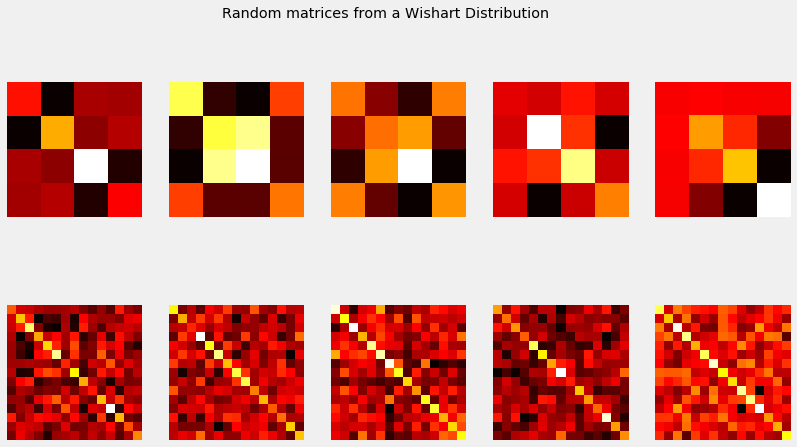

In [5]:
reset_sess()

n = 4
print('Output of the eye function \n(a commonly used function with Wishart Distributions):\n', np.eye(n))

plt.figure(figsize=(12.5, 7))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    if i >= 5:
        n = 15
    [
        wishart_matrices_
    ] = evaluate([
        tfd.Wishart(df=(n+1), scale=tf.eye(n)).sample()
    ])
    plt.imshow( wishart_matrices_,
              interpolation='none',
              cmap='hot')
    ax.axis('off')
    
plt.suptitle('Random matrices from a Wishart Distribution')

### Beta distribution

$$
f_X(x |\alpha, \beta) = \frac{x^{(\alpha-1)}(1-x)^{(\beta-1)}}{B(\alpha,\beta)}
$$

where $B$ is the Beta function. The random variable $X$ is only allowed in [0, 1], making the Beta distribution a popular distribution for decimal values, probabilities and proportions. The values of $\alpha$ and $\beta$, both positive values, provide great flexibility in the shape of the distribution.

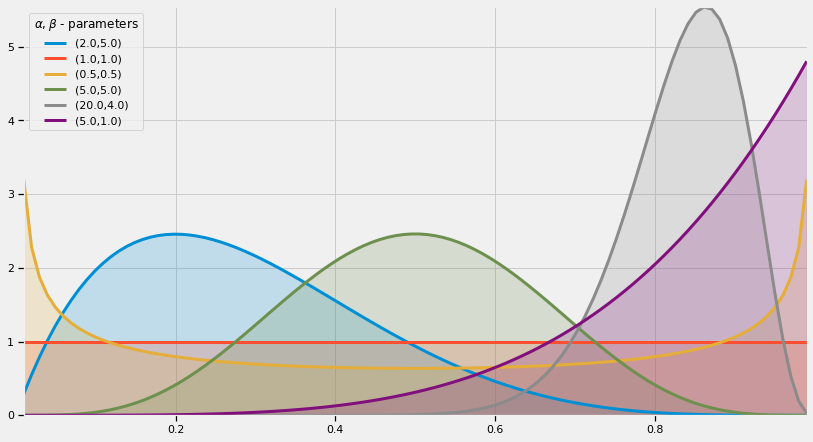

In [6]:
reset_sess()

params = [(2, 5), (1, 1), (0.5, 0.5), (5, 5), (20, 4), (5, 1)]
x = tf.cast(tf.linspace(start=0.01, stop=.99, num=100), dtype=tf.float32)

plt.figure(figsize=(12.5, 7))
for alpha, beta in params:
    [
        y_, 
        x_
    ] = evaluate([
        tfd.Beta(float(alpha), float(beta)).prob(x),
        x
    ])
    lines = plt.plot(x_, y_, label="(%.1f,%.1f)" % (alpha, beta), lw=3)
    plt.fill_between(x_, 0, y_, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
plt.ylim(0)
plt.legend(title=r'$\alpha, \beta$ - parameters');

## Bayesian Bandits
Bayesian solution begins by assuming priors on the probability of winning for each bandit. In our vignette we assumed complete ignorance of these probabilities. So a very natural prior is the flat prior over 0 to 1. The algorithm proceeds as follows:

For each round:

1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
2. Select the bandit with largest sample, i.e. select $B = \mathrm{argmax} X_b$.
3. Observe the result of pulling bandit $B$, and update your prior on bandit $B$.
4. Return to 1.

That's it. Computationally, the algorithm involves sampling from $N$ distributions. Since 